# Equation of State and Thermodynamics

Suppose we have energy density $\mathcal{E}(n)$.

In [1]:
import mmf_setup;mmf_setup.nbinit()
%pylab inline --no-import-all
from nbimports import *
from mmf_hfb.BCSCooling import BCSCooling
import matplotlib.pyplot as plt
from mmfutils import plot as mmfplt            
import numpy as np
import numpy
import time
import sympy

<IPython.core.display.Javascript object>

In [2]:
n_ = sympy.var('n', positive=True)
E_ = (n_**2-1)**2
mu_ = E_.diff(n_)
P_ = mu_*n_ - E_
E, mu, P = [sympy.lambdify([n_], f_)
            for f_ in [E_, mu_, P_]]

In [3]:
n_ = sympy.var('n', real=True)
E0_ = (n_**2-1)**2
E_ = sympy.Piecewise((E0_.subs(n_,0)-100*n_, n_<0), (E0_, True))
mu_ = E_.diff(n_)
P_ = mu_*n_ - E_
E, mu, P = [sympy.lambdify([n_], f_)
            for f_ in [E_, mu_, P_]]

[(-2, 1), Text(0, 0.5, '(E-E_0)/n'), Text(0.5, 0, 'n')]

<Figure size 1080x432 with 0 Axes>

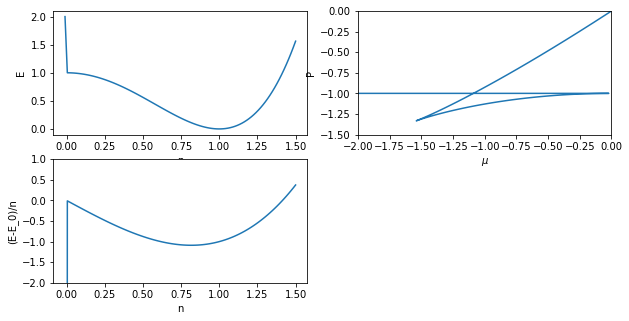

In [4]:
plt.figure(figsize=(15, 6))
n = np.linspace(-0.01, 1.5, 100)
plt.figure(figsize=(10,5))
ax = plt.subplot(221);
ax.plot(n, E(n))
ax.set(xlabel='n', ylabel='E')
ax = plt.subplot(222)
ax.plot(mu(n), P(n))
ax.set(xlabel=r'$\mu$', ylabel='P', xlim=(-2,0), ylim=(-1.5,0))
ax = plt.subplot(223)
ax.plot(n, (E(n)-E(0))/n)
ax.set(xlabel=r'n', ylabel='(E-E_0)/n', ylim=(-2, 1))

Populating the interactive namespace from numpy and matplotlib


c:\users\chunde\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


(-1.5, 1)

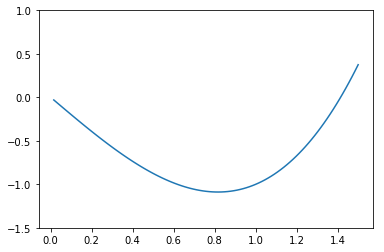

In [5]:
%pylab inline --no-import-all

def E(n, d=0):
    if d == 0:
        return (n**2-1)**2-1
    elif d == 1:
        return 4*n*(n**2-1)
    elif d == 2:
        return 12*n**2-4
    elif d == 3:
        return 24*n

def mu(n, d=0):
    return E(n, d=1+d)

def P(n, d=0):
    if d == 0:
        return mu(n)*n - E(n)
    elif d == 1:
        return mu(n, d=1)*n + mu(n) - E(n, d=1)

n = np.linspace(0,1.5,100)
plt.plot(n, E(n)/n)
plt.ylim(-1.5,1)

# 2D BCS Cooling

In [6]:
def plot_occupancy_k(b, psis):
    n_k = 0
    ks = b.kxyz
    for psi in psis:
        n_k += abs(b.fft(psi))**2
    n_k = np.fft.fftshift(n_k)
    ks = np.fft.fftshift(ks)   
    plt.plot(ks, n_k)
    plt.xlabel("k")
    plt.ylabel("n_k")

In [95]:
class FissionCooling(BCSCooling):
    """Fission Potential??"""
    pass
#     def get_Vint(self, psis):
#         ns = self.get_ns(psis)
#         return (ns**2 - 1)**2

In [169]:

def Cooling(plot=True, N_state=2, plot_dE=True, T=0.5, log=False, **args):  
    b = FissionCooling(**args)
    x, y = b.xyz
    #b.g = -1
    x0 = 0.5
    V = sum(w*_x**2 for (_x, w) in zip(b.xyz, (1, 9)))
    mmfplt.imcontourf(x, y, V)
    plt.show()
    H0 = b._get_H(mu_eff=0, V=V)
    V = sum(_x**2 for _x in b.xyz)
    b.V = V/2
    H1 = b._get_H(mu_eff=0, V=V)
    U0, E0 = b.get_U_E(H0, transpose=True)
    U1, E1 = b.get_U_E(H1, transpose=True)
    psi0 = [b.Normalize(U1[i]) for i in range(N_state)]
    phase = ((x-x0) + 1j*y)*((x+x0) - 1j*y)
    psi =  [b.Normalize(U0[i]) for i in range(N_state)] # b.Normalize(1.0*np.exp(1j*np.angle(phase))) #
    start_time = time.time()
    ts, psis, nfev = b.solve([psi], T=T, rtol=1e-5, atol=1e-6,solver=None, method='BDF')
    wall_time = time.time() - start_time
    if plot:
        E0, _ = b.get_E_Ns(psis[-1])
        Es = [b.get_E_Ns(_psi)[0] for _psi in psis]
        dE_dt= [-1*b.get_dE_dt(_psi) for _psi in psis]
        for i in range(N_state):
            b.plot(psis[-1][i])
        plt.plot(ts, Es)
    print(f"Wall Time={wall_time}, nfev={nfev}")
    return (wall_time, nfev, b, psis)

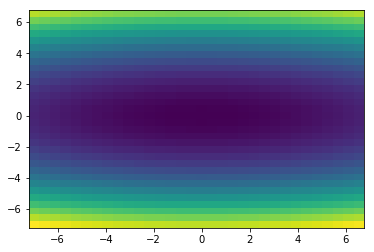

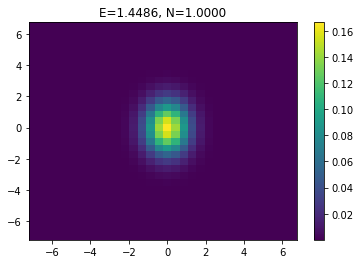

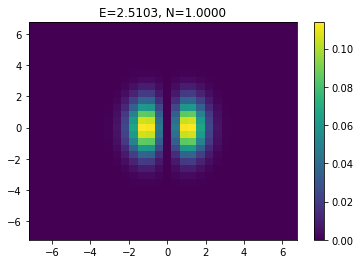

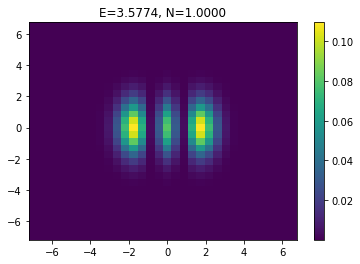

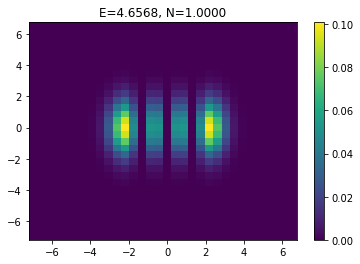

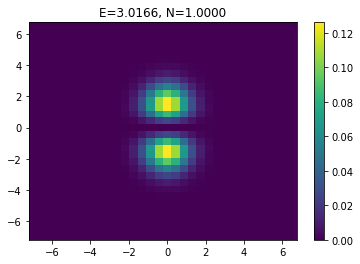

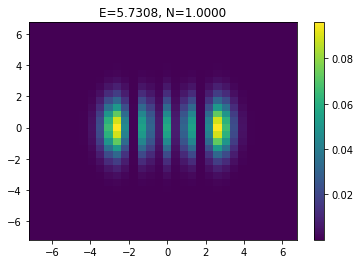

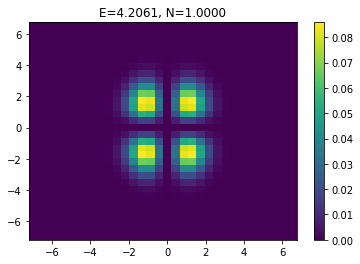

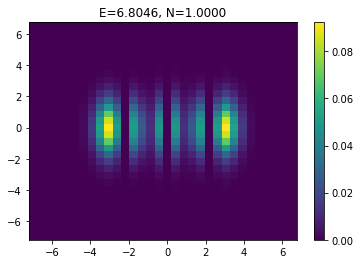

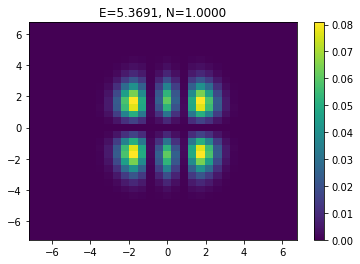

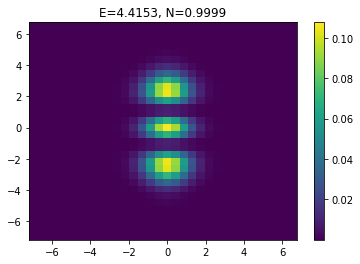

Wall Time=39450.38907790184, nfev=441


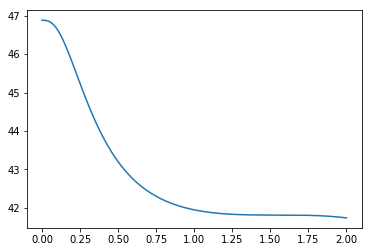

In [200]:
args = dict(N=32, dx=0.45, dim=2, N_state=10,  beta_0=1, beta_V=0.2, T=2, log=False, check_dE=False)
wall_time, nfev, b, psis=Cooling(**args)

In [155]:
def plot_occupancy_k(b, psis):
    n_k = 0
    kx, ky = b.kxyz
    kx = kx.T[0]
    ky = ky[0]
    x, y = b.xyz
    for psi in psis:
        n_k += abs(b.fft(psi))**2
    n_k = np.fft.fftshift(n_k)
    kx, ky = np.fft.fftshift(kx), np.fft.fftshift(ky)
    #print(ks)
    mmfplt.imcontourf(x, y, n_k)
    plt.colorbar()

In [171]:
psis[0][0].shape

(16, 16)

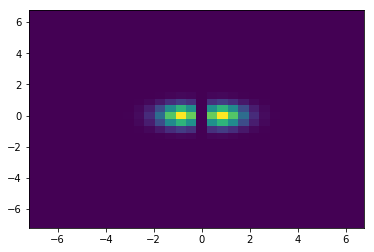

In [201]:
x, y = b.xyz
mmfplt.imcontourf(x,y, abs(psis[0][1]))

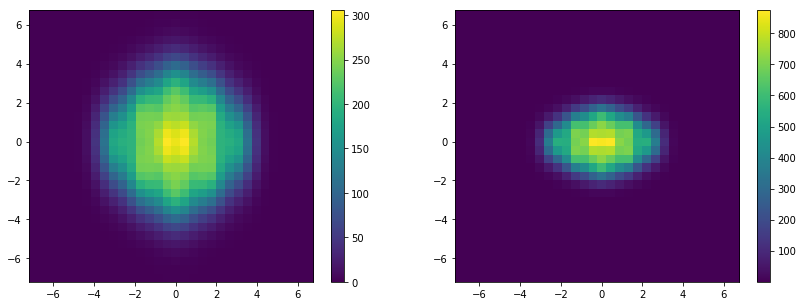

In [202]:
plt.figure(figsize=(14, 5))
plt.subplot(121)
plot_occupancy_k(b, psis[0])
plt.subplot(122)
plot_occupancy_k(b, psis[-1])

# Cooling with Pairing
* Now only V_C works, K_c has some issue. But V_c may also has some issue as the enery may oscillate sometime.

In [22]:
def plot_psis(psis, s='--'):
    l = None
    for psi in psis:
        if l is not None:
            l, = plt.plot(abs(psi)**2,s, c=l.get_c())
        else:
            l, = plt.plot(abs(psi)**2,s)

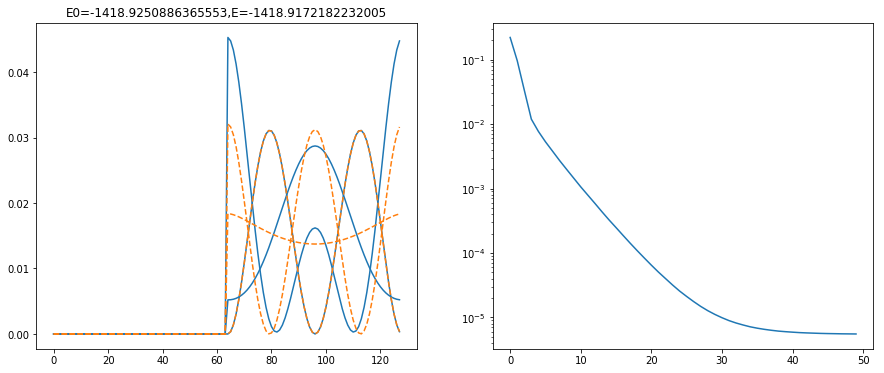

In [74]:
b = BCSCooling(N=64, dx=0.1,beta_V=1, delta=1, mus=(2, 2))
x = b.xyz[0]
V0 = x**2
V1 = x**2/2
H0 = b.get_H(mus_eff=b.mus, delta=b.delta, Vs=(V0, V0))
H1 = b.get_H(mus_eff=b.mus, delta=b.delta, Vs=(V1, V1))
U0, Es0 = b.get_U_E(H0, transpose=True)
U1, Es1 = b.get_U_E(H1, transpose=True)
psis0 = U1[:3]
psis = U0[7:10]
b.V = V1
E0, N0 = b.get_E_Ns(psis=psis0)
Es = []
for i in range(50):
    plt.figure(figsize=(15, 6))
    psis = b.step(psis=psis, n=300)
    plt.subplot(121)    
    plot_psis(psis,'-')
    plot_psis(psis0,'--')
    E, N = b.get_E_Ns(psis=psis)
    Es.append(E)
    plt.title(f"E0={E0.real},E={E.real}")
    plt.subplot(122)
    plt.semilogy(abs((np.array(Es)-E0)/E0))
    plt.show()
    
    clear_output(wait=True)

In [72]:
b = BCSCooling(N=128, dx=0.1)
x = b.xyz[0]
V = x**2/2
b.V = V
H0 = b._get_H(mu_eff=0, V=V)
psis0, Es0 = b.get_U_E(H0, transpose=True)
H = b._get_H(mu_eff=0, V=0)
psis, _ = b.get_U_E(H, transpose=True)
for n, T in zip([2,3,4,5],[5,2,2,2]):
   
    psis_init = [b.Normalize(psis[i]) for i in range(n)]

    def compute_dy_dt(t, psis, **args):
        """Return dy/dt for ODE integration."""
        psis = b.unpack(y=psis)
        Hc = b.get_Hc(psis=psis)
        Hpsis = (Hc.dot(psis.T)).T
        for i, psi in enumerate(psis):
            Hpsis[i] -= b.dotc(psi, Hpsis[i])/b.dotc(psi, psi)*psi
        return b.pack(np.array(Hpsis)/(1j*b.hbar))

    ts, ys, nfev = b.solve(
        psis=psis_init, T=T, dy_dt=compute_dy_dt,
        rtol=1e-5, atol=1e-6, method='BDF')
    E, N= b.get_E_Ns(psis=ys[-1])
    E0 = np.sum(Es0[:n])
    print(f"State Num={n}, E0={E0},E={E},N={N}, nfev={nfev}")
    assert np.allclose(E, E0, rtol=1e-2)

State Num=2, E0=1.9999999999999107,E=2.0080814400062343,N=1.9999390334563527, nfev=457
State Num=3, E0=4.49999999999978,E=4.4999320396194795,N=2.9999517089139065, nfev=237
State Num=4, E0=8.00000000000079,E=7.999897023869867,N=3.999944964952183, nfev=230
State Num=5, E0=12.499999999983483,E=12.499792003372711,N=4.999929670897348, nfev=231
